# XGBoost
## Final Model
### Used to predict future *close* values
(Assign 0/1 to each day based on whether the close price is higher/lower than the previous day)

# Libraries

In [522]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Import data

In [409]:
# Leer los datos
data = pd.read_csv('data/train_cleaned_v2_1.csv', index_col='Time', parse_dates=True)
df = data.copy()
df = pd.DataFrame(df['Close'])

In [410]:
df

,Close
Time,
2007-03-07,1.316480
2007-03-08,1.313960
2007-03-09,1.311180
2007-03-10,1.297538
2007-03-11,1.311750
...,...
2018-05-19,1.176343
2018-05-20,1.174740
2018-05-21,1.179130


<Axes: xlabel='Time'>

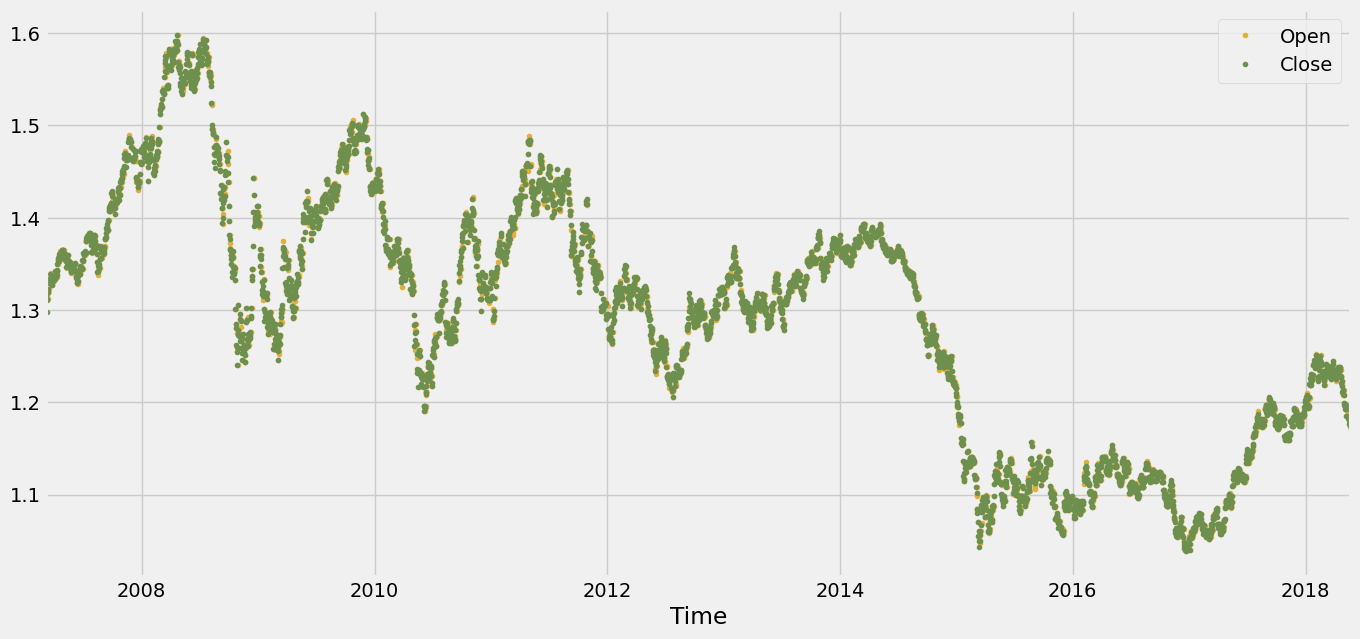

In [517]:
data[['Open', 'Close']].plot(figsize=(15, 7),
                            color=color_pal[2:4],
                            style='.')

# Split data

In [412]:
train = df.loc[df.index < '01-01-2016']
val = df.loc[df.index >= '01-01-2016']

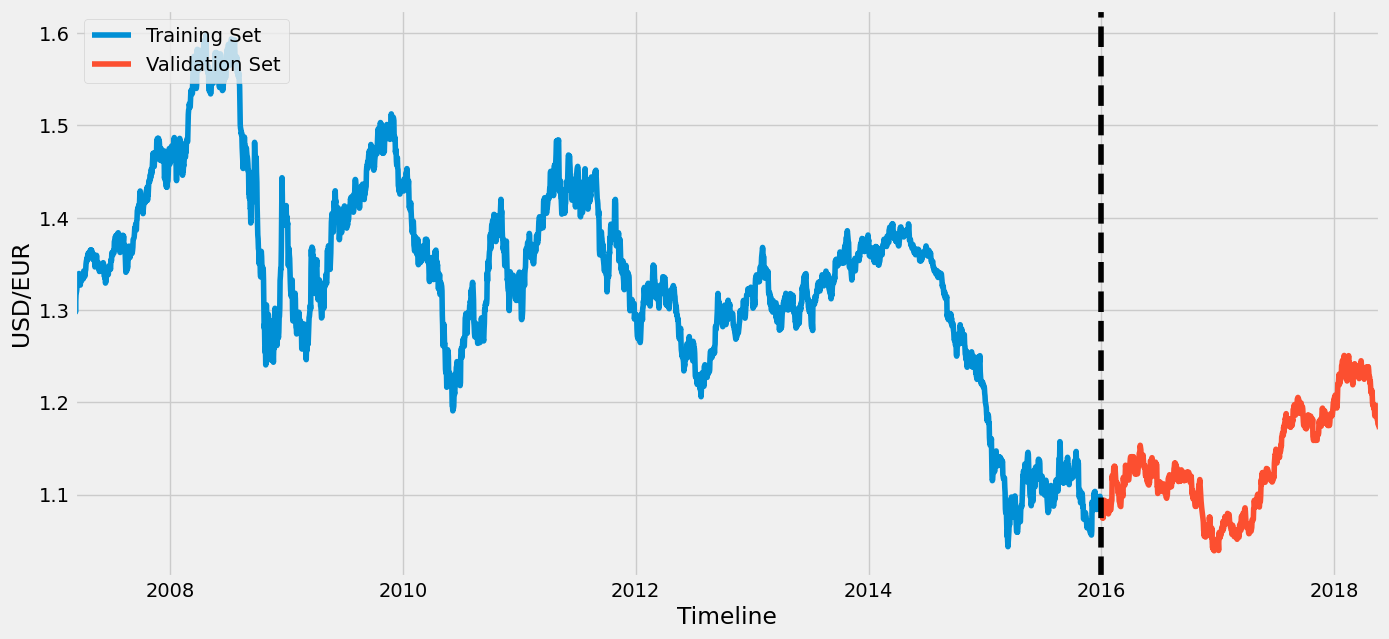

In [519]:
fig, ax = plt.subplots(figsize=(15, 7))
train['Close'].plot(ax=ax, label='Training Set')
val['Close'].plot(ax=ax, label='Validation Set')
ax.axvline('01-01-2016', color='Black', linestyle='--')
ax.legend(loc='upper left')
ax.set_xlabel('Timeline')
ax.set_ylabel('USD/EUR')
plt.show()

# Create features

<Axes: xlabel='Time'>

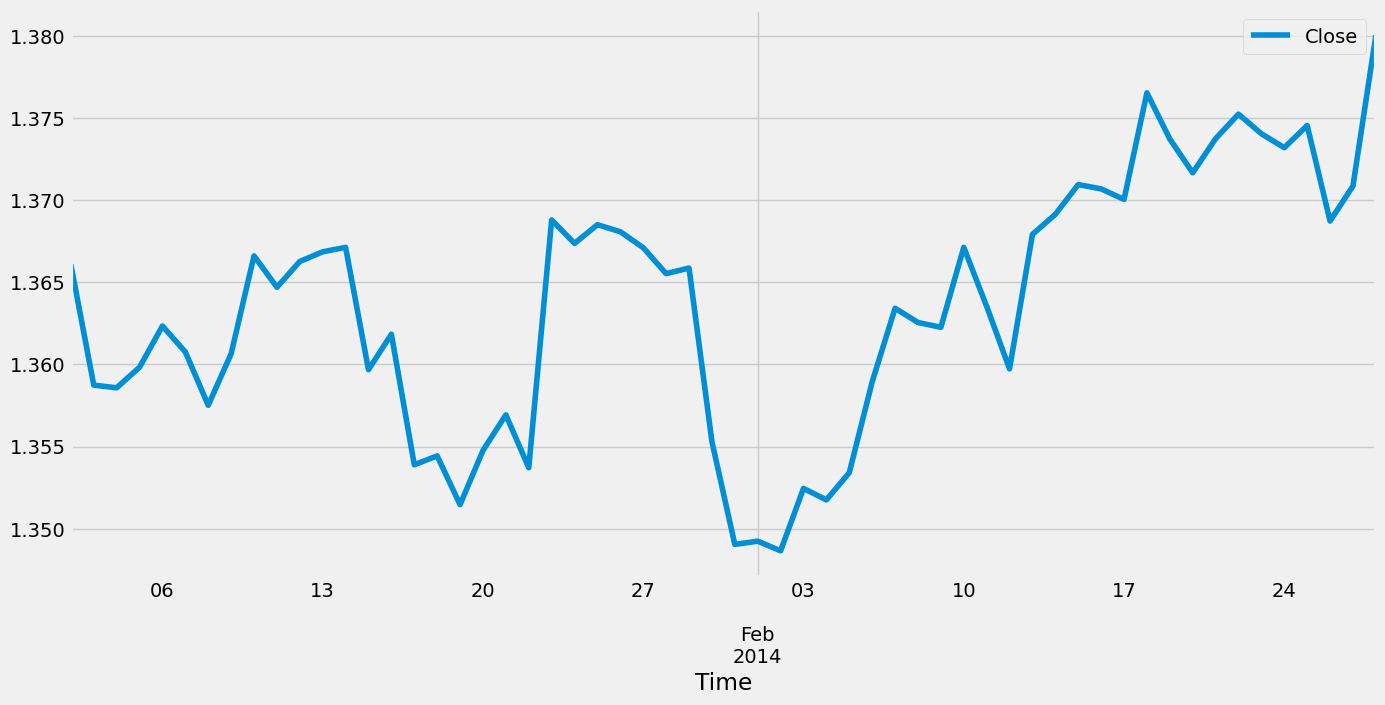

In [414]:
df.loc[(df.index > '01-01-2014') & (df.index < '03-01-2014')].plot(figsize=(15, 7))

In [415]:
df

,Close
Time,
2007-03-07,1.316480
2007-03-08,1.313960
2007-03-09,1.311180
2007-03-10,1.297538
2007-03-11,1.311750
...,...
2018-05-19,1.176343
2018-05-20,1.174740
2018-05-21,1.179130


In [416]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year

    # Create lag features
    df['lag1'] = df['Close'].shift(1)
    df['lag2'] = df['Close'].shift(2)
    df['lag3'] = df['Close'].shift(3)

    # Create rolling window statistics
    #df['rolling_mean'] = df['Close'].rolling(window=3).mean()
    df['rolling_std'] = df['Close'].rolling(window=3).std()
    return df

In [417]:
df = create_features(df)

In [418]:
df

,Close,quarter,month,year,lag1,lag2,lag3,rolling_std
Time,,,,,,,,
2007-03-07,1.316480,1,3,2007,NaN,NaN,NaN,NaN
2007-03-08,1.313960,1,3,2007,1.316480,NaN,NaN,NaN
2007-03-09,1.311180,1,3,2007,1.313960,1.316480,NaN,0.002651
2007-03-10,1.297538,1,3,2007,1.311180,1.313960,1.316480,0.008789
2007-03-11,1.311750,1,3,2007,1.297538,1.311180,1.313960,0.008046
...,...,...,...,...,...,...,...,...
2018-05-19,1.176343,2,5,2018,1.176890,1.180520,1.181140,0.002270
2018-05-20,1.174740,2,5,2018,1.176343,1.176890,1.180520,0.001117
2018-05-21,1.179130,2,5,2018,1.174740,1.176343,1.176890,0.002221


# Feature/Target Relationships

Text(0.5, 1.0, 'Close by Quarter')

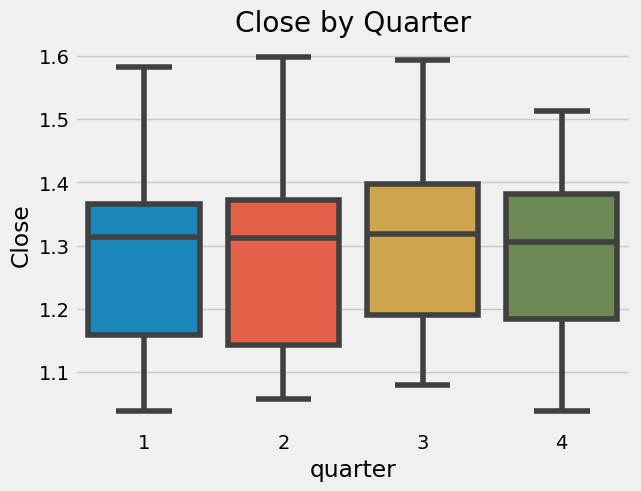

In [419]:
sns.boxplot(data=df, x='quarter', y='Close')
plt.title("Close by Quarter")

Text(0.5, 1.0, 'Close by Month')

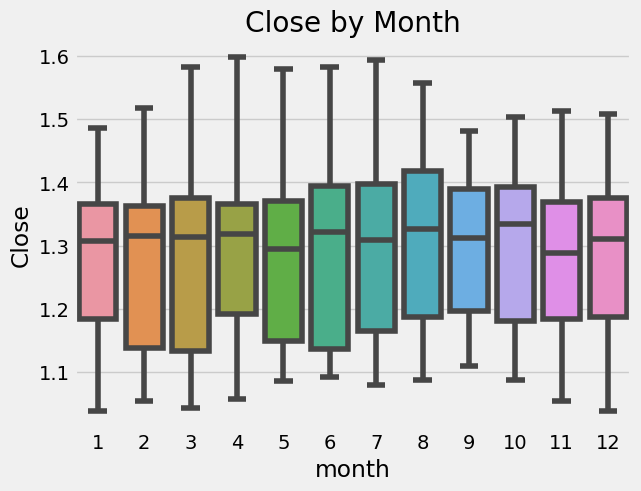

In [420]:
sns.boxplot(data=df, x='month', y='Close')
plt.title("Close by Month")

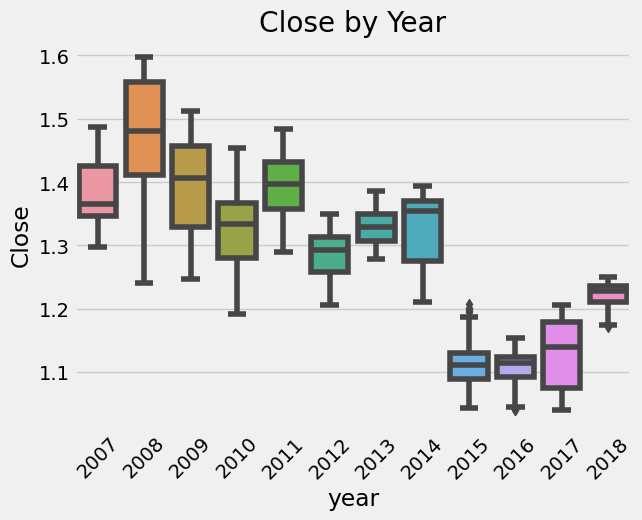

In [516]:
sns.boxplot(data=df, x='year', y='Close')
plt.title("Close by Year")
plt.xticks(rotation=45);

# Create model

In [422]:
train = create_features(train)
val = create_features(val)

FEATURES = ['quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'rolling_std']
TARGET = 'Close'

In [423]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]

In [444]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [0.1, 0.3, 0.5]
}

One way of avoiding overfitting or relying too much on a single variable, is to use regularization techniques. Regularization adds a penalty term to the loss function that the model is trying to minimize, which encourages the model to use simpler solutions and reduces its reliance on any single feature.

There are several types of regularization that you can use with XGBoost, including L1 regularization (also known as Lasso regularization) and L2 regularization (also known as Ridge regularization). L1 regularization adds a penalty term proportional to the absolute value of the feature weights, while L2 regularization adds a penalty term proportional to the square of the feature weights.

In [445]:
# Create the XGBoost model
reg = xgb.XGBRegressor()

In [446]:
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.1, 0.3, 0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'reg_lambda': [0.1, 0.3, 0.5]})

In [447]:
# Print the best hyperparameters
print(grid_search.best_params_)

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 0.1}


In [428]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

[0]	validation_0-rmse:0.59015	validation_1-rmse:0.44409
[99]	validation_0-rmse:0.00272	validation_1-rmse:0.01254


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [451]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01, alpha=0.1, reg_lambda=0.5)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

[0]	validation_0-rmse:0.83369	validation_1-rmse:0.63135
[100]	validation_0-rmse:0.30591	validation_1-rmse:0.22934
[200]	validation_0-rmse:0.11254	validation_1-rmse:0.08462
[300]	validation_0-rmse:0.04196	validation_1-rmse:0.03326
[400]	validation_0-rmse:0.01685	validation_1-rmse:0.01617
[500]	validation_0-rmse:0.00899	validation_1-rmse:0.01164
[600]	validation_0-rmse:0.00711	validation_1-rmse:0.01061
[700]	validation_0-rmse:0.00671	validation_1-rmse:0.01038
[800]	validation_0-rmse:0.00653	validation_1-rmse:0.01033
[900]	validation_0-rmse:0.00635	validation_1-rmse:0.01033
[903]	validation_0-rmse:0.00634	validation_1-rmse:0.01033


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

# Feature importance

In [452]:
fi = pd.DataFrame(reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance']).sort_values(by='Importance', ascending=False)

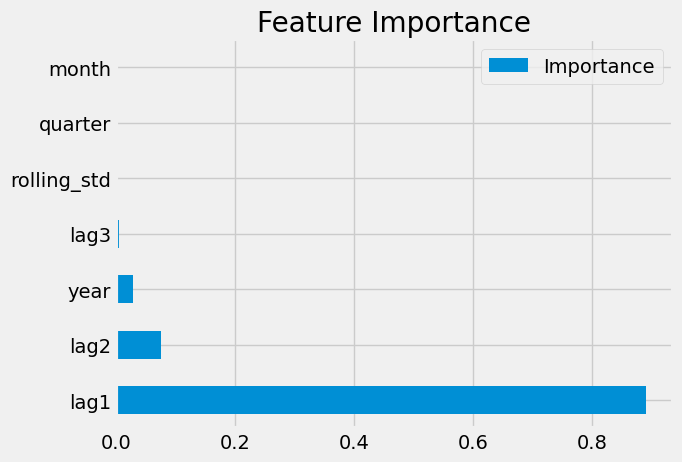

In [453]:
fi.plot(kind='barh', title='Feature Importance');

In [454]:
fi

,Importance
lag1,0.890601
lag2,0.075516
year,0.028367
lag3,0.004993
rolling_std,0.000239
quarter,0.000162
month,0.000123


# Forecast on Test

In [455]:
val['prediction'] = reg.predict(X_val)

In [456]:
df.merge(val,how='left',left_index=True,right_index=True)[['Close_x','Close_y']]

,Close_x,Close_y
Time,,
2007-03-07,1.316480,NaN
2007-03-08,1.313960,NaN
2007-03-09,1.311180,NaN
2007-03-10,1.297538,NaN
2007-03-11,1.311750,NaN
...,...,...
2018-05-19,1.176343,1.176343
2018-05-20,1.174740,1.174740
2018-05-21,1.179130,1.179130


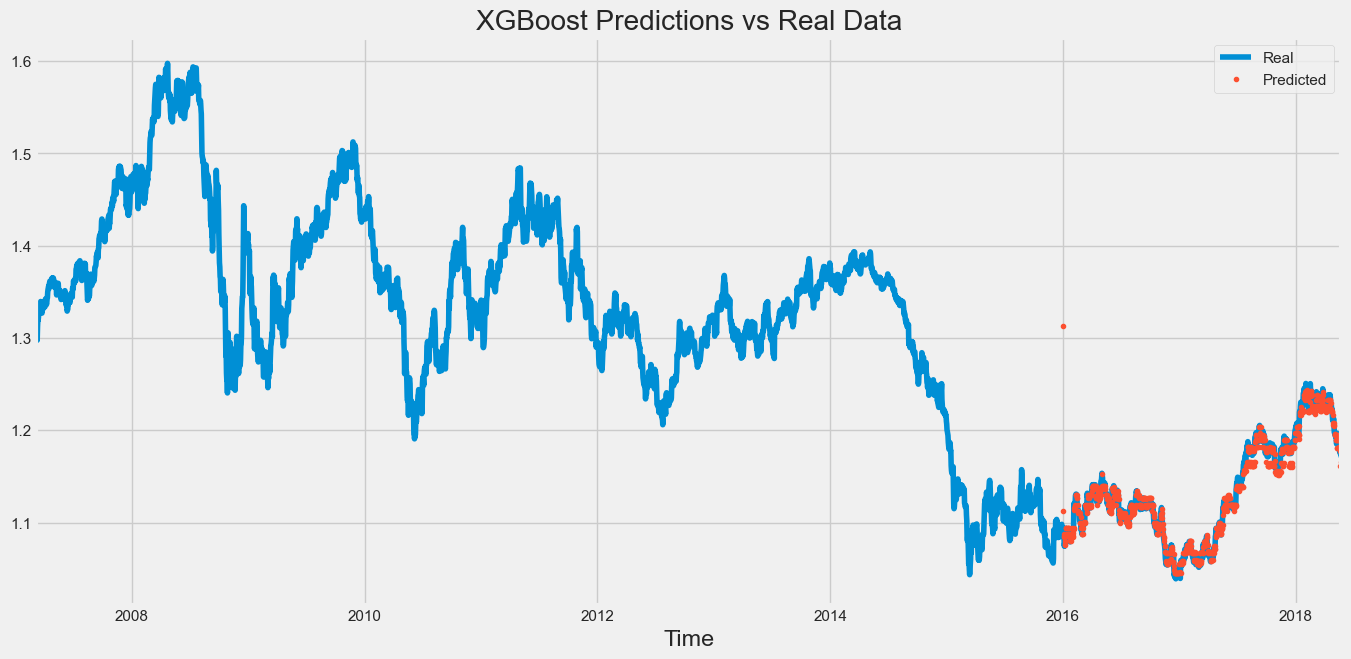

In [523]:
ax = df[['Close']].plot(figsize=(15, 7))
val['prediction'].plot(ax=ax, style='.', figsize=(15, 7))
plt.legend(['Real', 'Predicted'])
ax.set_title("XGBoost Predictions vs Real Data");

---
# Make predictions for actual test data

In [458]:
test = pd.read_csv('data/testing_set.csv', index_col='Time', parse_dates=True)

In [459]:
test = create_features(test)

X_test = test[FEATURES]
y_test = test[TARGET]

In [506]:
test['prediction'] = reg.predict(X_test)

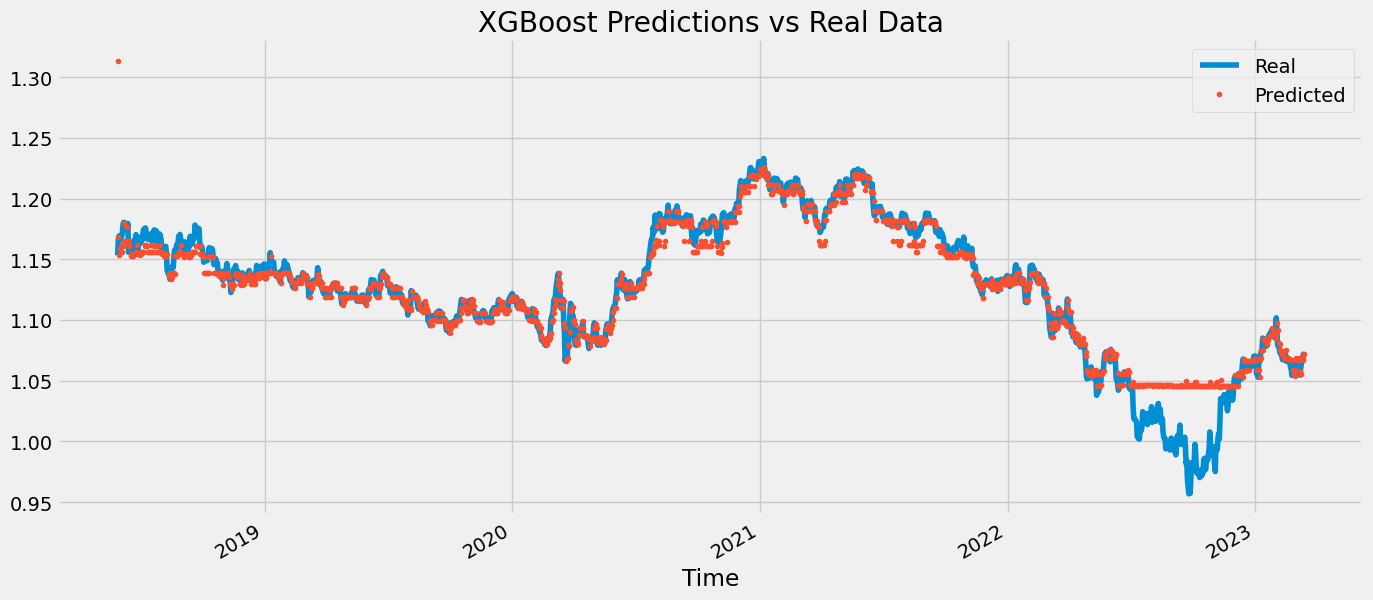

In [515]:
ax = test[['Close']].plot(figsize=(15, 7))
test['prediction'].plot(ax=ax, style='.', figsize=(15, 7))
plt.legend(['Real', 'Predicted'])
ax.set_title("XGBoost Predictions vs Real Data");

---
# Create labels

In [508]:
# Add predicted label to the test set, 0 if the close value is lower than the previous one, 1 otherwise
test['shifted'] = test['Close'].shift(1)
test['predicted_label'] = test.apply(lambda x: 0 if x['prediction'] < x['shifted'] else 1, axis=1)

In [511]:
# Crear un DataFrame con las predicciones
predictions = pd.DataFrame({"Id": test["test_idx"], "target": test.predicted_label})

In [512]:
predictions.target.value_counts()

target
0    953
1    547
Name: count, dtype: int64

In [513]:
# crear un json con la siguiente estructura
# {"target":
#   {
#     "0": 0,
#   },
#   {
#     "1": 0,
#   },
#   {
#     "n": k,
#   }
# }
# donde n es el índice del subconjunto de prueba y k es la predicción del modelo

import json

json_dict = {"target": {}}
for i in range(len(predictions)):
    json_dict["target"][str(i)] = int(predictions["target"][i])

# Convertir el diccionario a JSON
json_str = json.dumps(json_dict)

# Guardar el archivo json
with open("predictions.json", "w") as outfile:
    outfile.write(json_str)